In [53]:

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

df=pd.read_csv("price_smp.csv")
# ss=pd.read_csv("../input/tabular-playground-series-jul-2022/sample_submission.csv")
df.head()

,day,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,1/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,1/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,1/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,1/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,1/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [54]:
feats= ['8']

In [55]:
data= df['8']
data.head()

0     964.4
1    1019.7
2     988.4
3    1002.0
4    1061.5
Name: 8, dtype: float64

In [56]:
data.shape

(365,)

In [57]:
if len(data.shape) == 1:  # Check if 'data' is a Series
    data = pd.DataFrame(data)

In [58]:
# data=data.values.reshape()
transformer = PowerTransformer()
X=transformer.fit_transform(df)

ValueError: could not convert string to float: '1/01/2021'

In [ ]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)
df["Clusters"]= preds

In [ ]:
pp=BGM.predict_proba(X)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(X,columns=feats)
df_new[[f'predict_proba_{i}' for i in range(6)]]=pp # creating new dataframe columns of probabilites
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)

train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

ValueError: Columns must be same length as key

In [ ]:
#ricopue's notebook's code snippet
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7}

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)

    model = lgb.train(params = params_lgb,
                train_set = tr_dataset,
                valid_sets =  vl_dataset,
                num_boost_round = 5000,
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])

    model_list.append(model)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [ ]:
labels=np.argmax(lgb_preds,axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

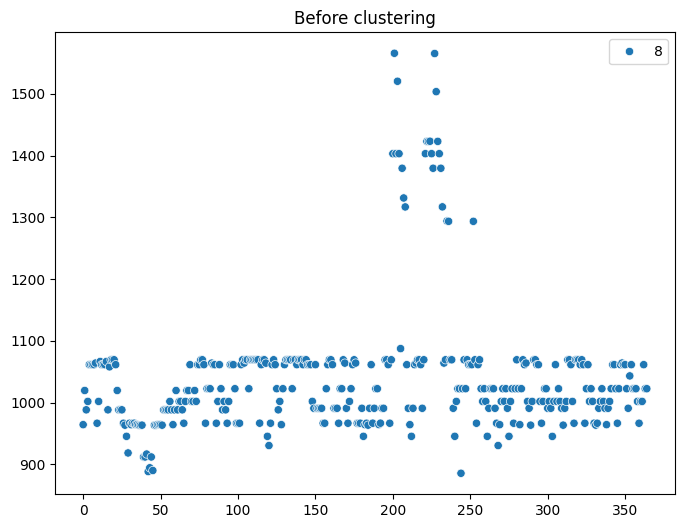

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(label="bla")
sns.scatterplot(df[feats], marker='o');
ax.set_title("Before clustering");

ValueError: 0      0
1      0
2      0
3      0
4      0
      ..
360    0
361    0
362    0
363    0
364    0
Name: Clusters, Length: 365, dtype: int64 is not a valid value for color

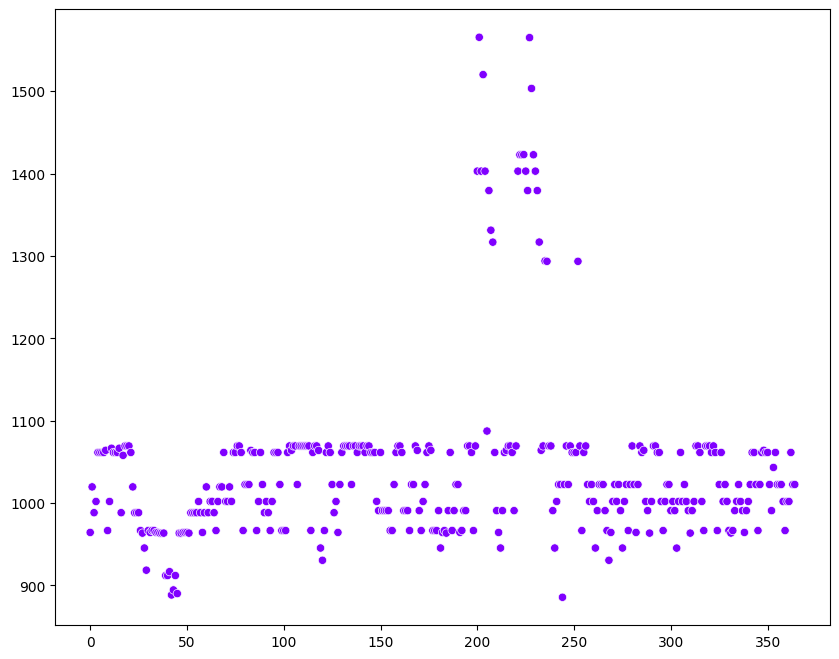

In [ ]:
fig = plt.figure(figsize=(10,8))
sns.scatterplot(df[feats], c=df["Clusters"], marker='o',cmap="rainbow");
ax.set_title("After Clustering");

In [ ]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [ ]:
df['day'] = pd.to_datetime(df['day'], format='%d/%m/%Y')
df.sort_values(by='day', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
test_size = df[df['day'].dt.month==12].shape[0]
test_size

31

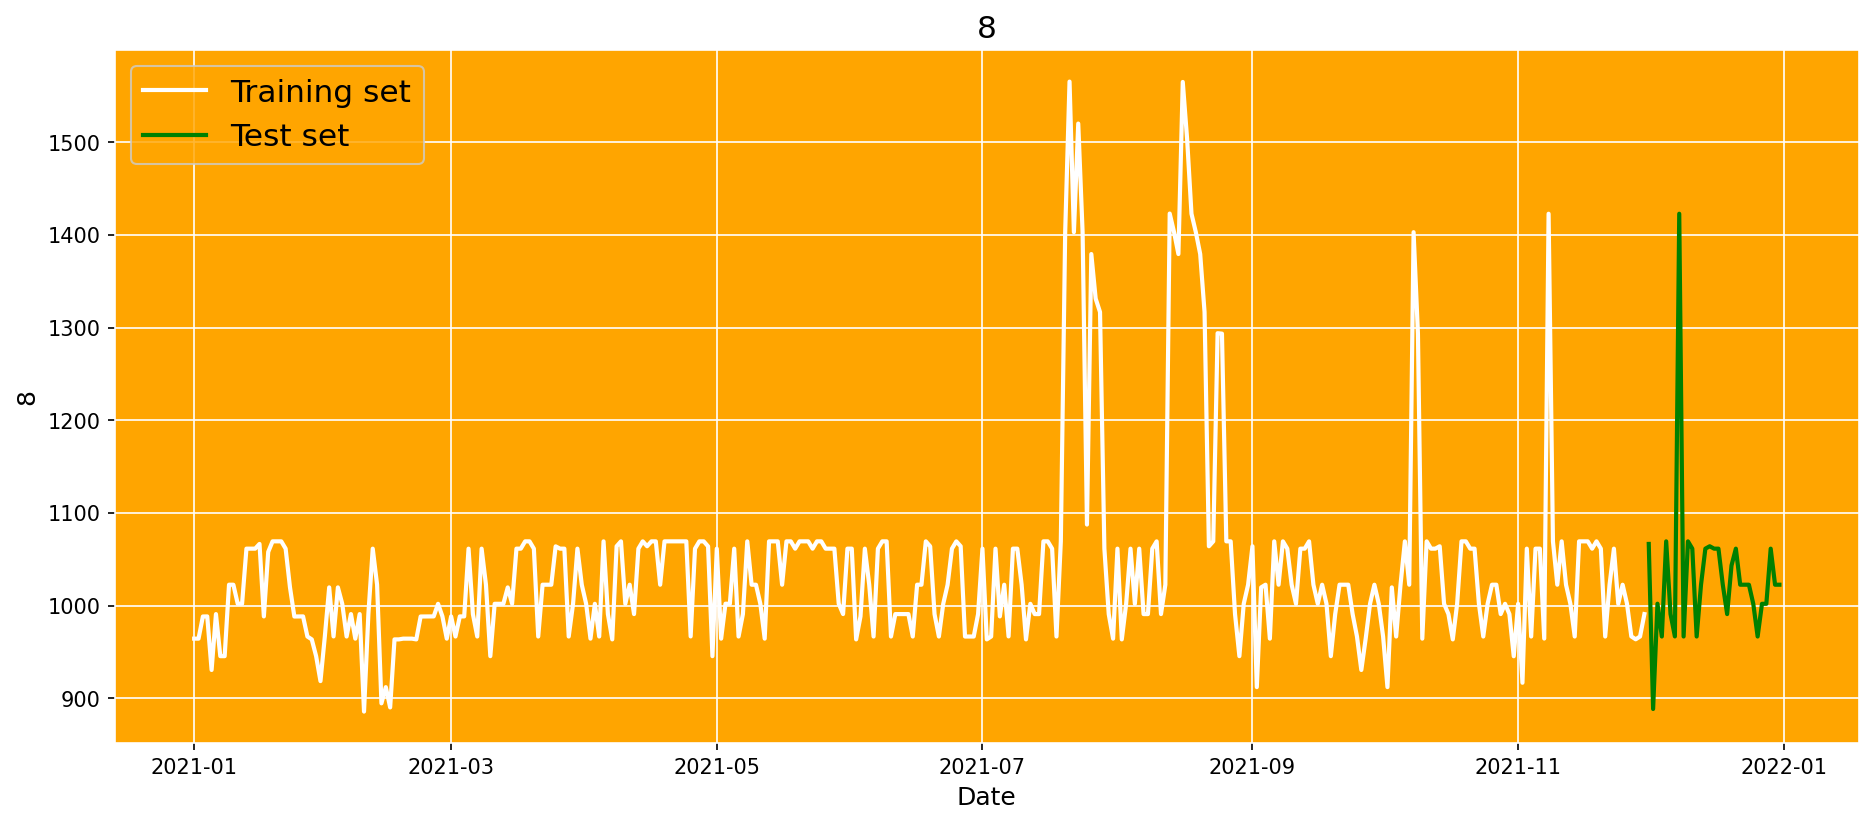

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'orange'
plt.rc('axes',edgecolor='white')
plt.plot(df['day'][:-test_size], df['8'][:-test_size], color='white', lw=2)
plt.plot(df['day'][-test_size:], df['8'][-test_size:], color='green', lw=2)
plt.title('8', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('8', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [ ]:
import plotly.express as px
fig = px.line(y=df['4'], x=df['Ngày'])
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Ngày",
                  yaxis_title="4",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(53,223,0,0.8)')

ModuleNotFoundError: No module named 'plotly'